Датасет взят с сайта [Kaggle](https://skillbox.ru/media/)

In [163]:
import nbconvert
from IPython.display import Image
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import statsmodels.api as sm

import scipy.stats as st
# импорт библиотеки warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [164]:
path = 'https://raw.githubusercontent.com/Grievver/files/main/AB_Test_Results.csv'


def load(path, info = True):
    
    import pandas as pd
    import io
    
    if len(path.split(".csv")) > 1:
        read = pd.read_csv(path)
    elif len(path.split(".xlsx")) > 1:
        read = pd.read_excel(path)
    
    if info:
        if len(read) > 0:
            print("# Данные загружены!")
            print(" ------------------------------------", "\n")
        
            print("# Размерность -------------------------")
            print("Количество строк:", read.shape[0], "Количество колонок:", read.shape[1], "\n")
    
            print("# Типы данных -----------------------------")
            if len(read.select_dtypes("object").columns) > 0:
                print("Тип данных Object:", "\n", "количество:", 
                      len(read.select_dtypes("object").columns), "\n", 
                      read.select_dtypes("object").columns.tolist(), "\n")
    
            if len(read.select_dtypes("integer").columns) > 0:
                print("Тип данных Int:", "\n", "количество:", 
                      len(read.select_dtypes("integer").columns), "\n", 
                      read.select_dtypes("integer").columns.tolist(), "\n")
    
            if len(read.select_dtypes("float").columns) > 0:
                print("Тип данных Float:", "\n", "количество:", 
                      len(read.select_dtypes("float").columns), "\n", 
                      read.select_dtypes("float").columns.tolist(), "\n")
    
            if len(read.select_dtypes("bool").columns) > 0:
                print("Тип данных Bool:", "\n", "количество:", 
                      len(read.select_dtypes("bool").columns), "\n", 
                      read.select_dtypes("bool").columns.tolist(), "\n")
    
            print("# Пропущенные значения -----------")
            print("Есть пропущенные значения? \n ", np.where(read.isnull().values.any() == False, 
                                                            "Нет пропущенных значений!", "Есть пропущенные значения!"), "\n")
            
            buf = io.StringIO()
            read.info(buf=buf)
            info = buf.getvalue().split('\n')[-2].split(":")[1].strip()
            print("# Используемый объем памяти ---------------------- \n", info)
          
        else:
            print("# Данные не импортированы!")
    
    return read
    
ab = load(path, info = True)
ab.head()

# Данные загружены!
 ------------------------------------ 

# Размерность -------------------------
Количество строк: 10000 Количество колонок: 3 

# Типы данных -----------------------------
Тип данных Object: 
 количество: 1 
 ['VARIANT_NAME'] 

Тип данных Int: 
 количество: 1 
 ['USER_ID'] 

Тип данных Float: 
 количество: 1 
 ['REVENUE'] 

# Пропущенные значения -----------
Есть пропущенные значения? 
  Нет пропущенных значений! 

# Используемый объем памяти ---------------------- 
 234.5+ KB


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [165]:
print(ab.USER_ID.nunique() == ab.shape[0])
ab = ab.drop_duplicates()
ab = ab.reset_index(drop=True)
ab.describe()

False


,USER_ID,REVENUE
count,7933.000000,7933.000000
mean,4976.885289,0.125359
std,2892.278447,2.602527
min,2.000000,0.000000
25%,2460.000000,0.000000
50%,4965.000000,0.000000
75%,7505.000000,0.000000
max,10000.000000,196.010000


In [166]:
ab.groupby("VARIANT_NAME").REVENUE.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
VARIANT_NAME,,,,,
control,3973,0.0,0.161842,3.367815,196.01
variant,3960,0.0,0.088755,1.479239,58.63


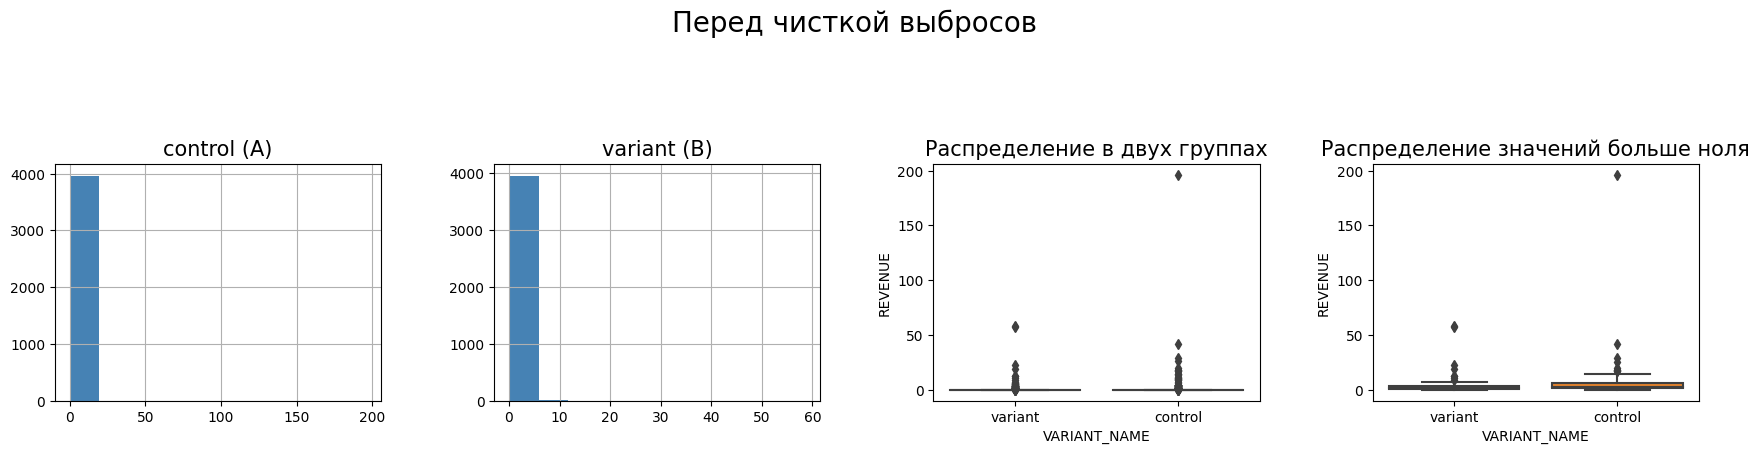

In [167]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
ab[(ab.VARIANT_NAME == "control")].hist("REVENUE", ax = axes[0], color = "steelblue")
ab[(ab.VARIANT_NAME == "variant")].hist("REVENUE", ax = axes[1], color = "steelblue")


sns.boxplot(x = ab.VARIANT_NAME, y = ab.REVENUE, ax = axes[2])
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = ab[ab['REVENUE'] > 0])

plt.suptitle("Перед чисткой выбросов", fontsize = 20)
axes[0].set_title("control (A)", fontsize = 15)
axes[1].set_title("variant (B)", fontsize = 15)
axes[2].set_title("Распределение в двух группах", fontsize = 15)
axes[3].set_title("Распределение значений больше ноля", fontsize = 15)



plt.tight_layout(pad = 4);

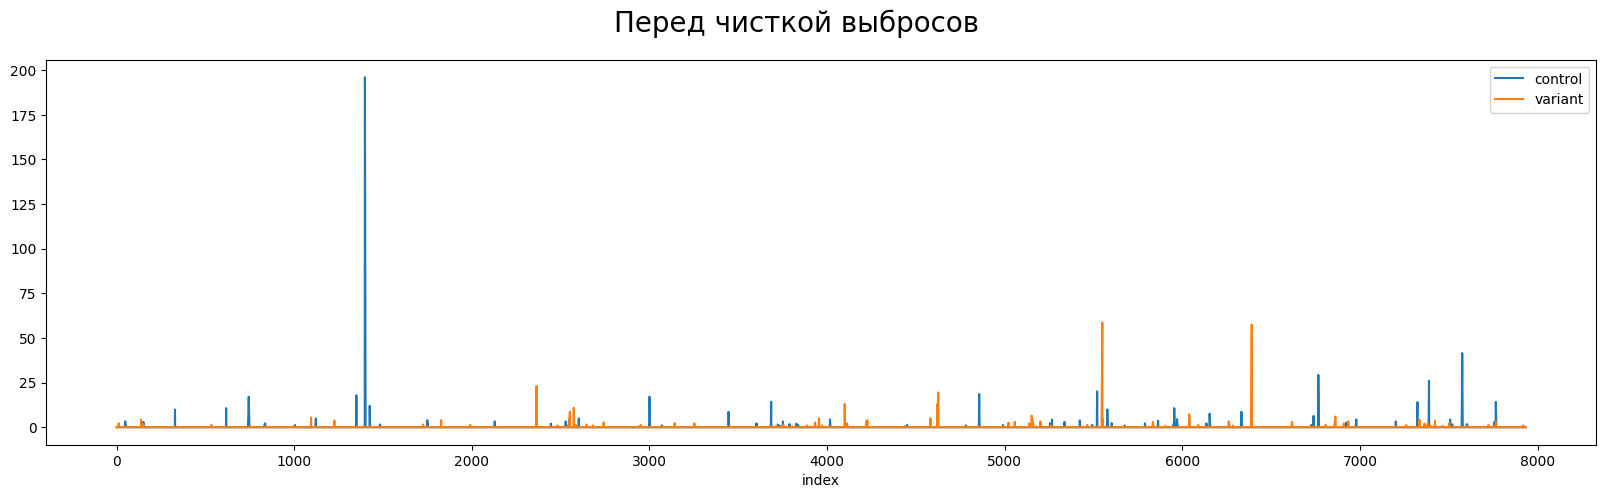

In [168]:
ab[ab.VARIANT_NAME == "control"].reset_index().set_index("index").REVENUE.plot(legend = True, label = "control", figsize = (20,5))
ab[ab.VARIANT_NAME == "variant"].reset_index().set_index("index").REVENUE.plot(legend = True, label = "variant")
plt.suptitle("Перед чисткой выбросов", fontsize = 20);

In [169]:
Q3 = ab.REVENUE.quantile(q=.99)
IQR = ab.REVENUE.apply(st.iqr)
ab = ab[~((ab.REVENUE > Q3))]
ab.groupby("VARIANT_NAME").REVENUE.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
VARIANT_NAME,,,,,
control,3928,0.0,0.011566,0.138737,2.22
variant,3925,0.0,0.010818,0.127030,2.17


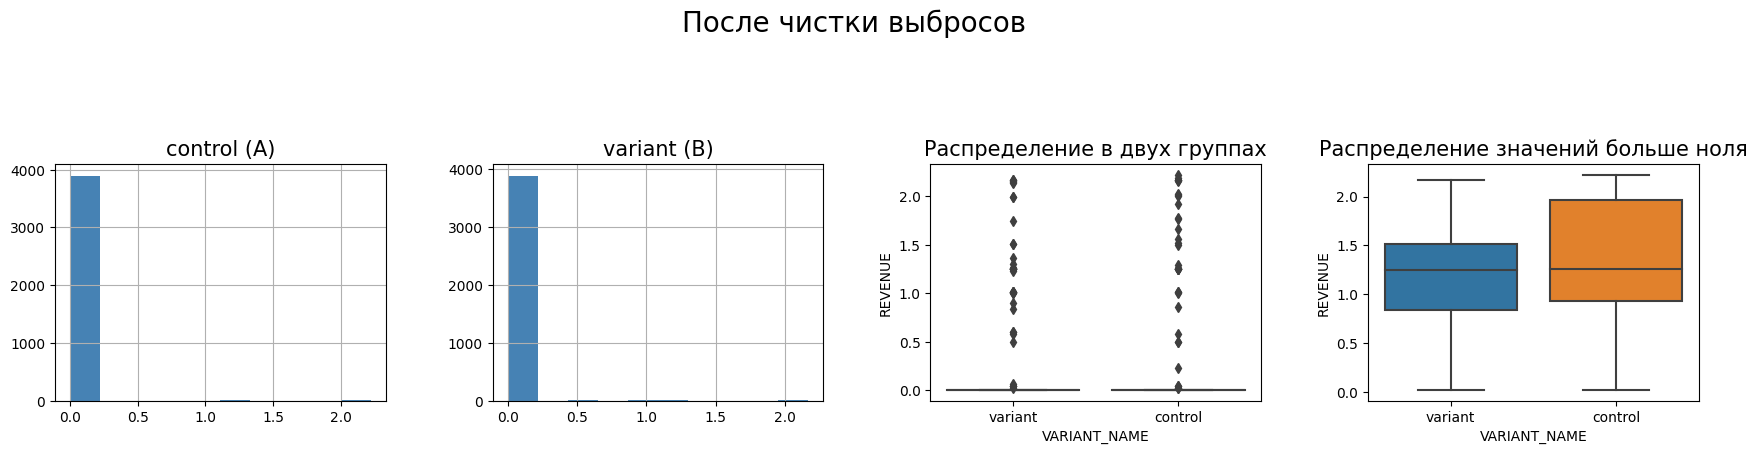

In [170]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
ab[(ab.VARIANT_NAME == "control")].hist("REVENUE", ax = axes[0], color = "steelblue")
ab[(ab.VARIANT_NAME == "variant")].hist("REVENUE", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.VARIANT_NAME, y = ab.REVENUE, ax = axes[2])
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = ab[ab['REVENUE'] > 0])

plt.suptitle("После чистки выбросов", fontsize = 20)
axes[0].set_title("control (A)", fontsize = 15)
axes[1].set_title("variant (B)", fontsize = 15)
axes[2].set_title("Распределение в двух группах", fontsize = 15)
axes[3].set_title("Распределение значений больше ноля", fontsize = 15)


plt.tight_layout(pad = 4);

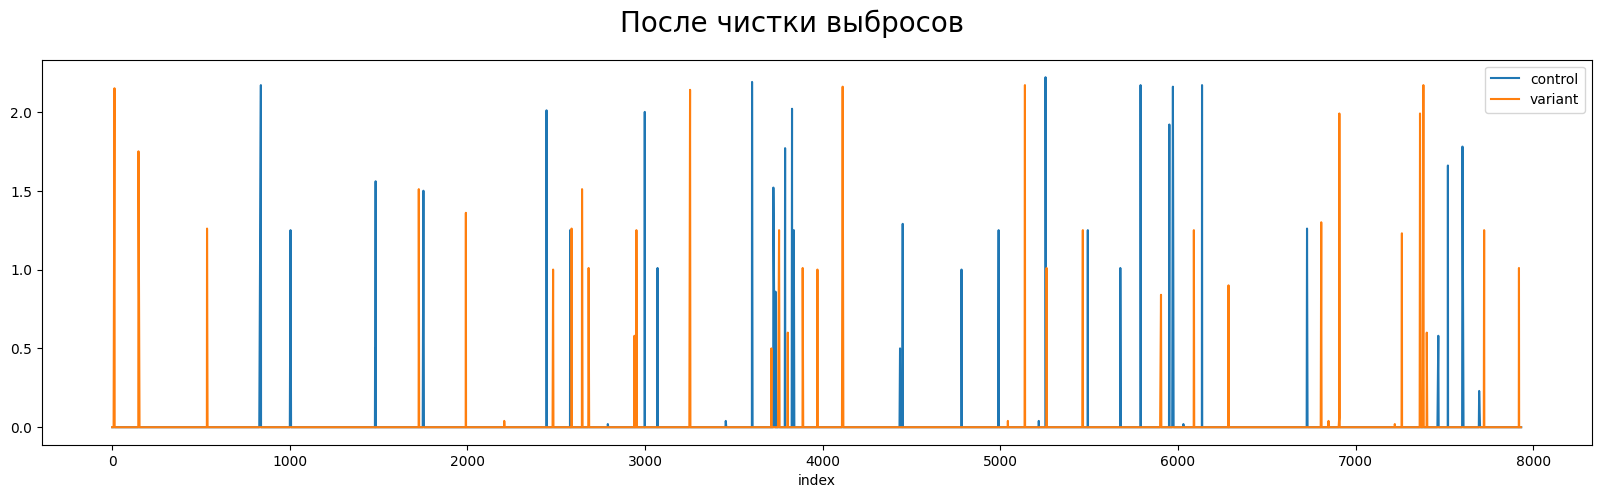

In [171]:
ab[ab.VARIANT_NAME == "control"].reset_index().set_index("index").REVENUE.plot(legend = True, label = "control", figsize = (20,5))
ab[ab.VARIANT_NAME == "variant"].reset_index().set_index("index").REVENUE.plot(legend = True, label = "variant")
plt.suptitle("После чистки выбросов", fontsize = 20);

In [172]:
ab.USER_ID.value_counts().sort_values(ascending = True)

USER_ID
1852    1
4376    1
9608    1
7271    1
8585    1
       ..
6678    3
9669    3
9526    3
5053    3
1252    3
Name: count, Length: 6294, dtype: int64

In [173]:
ab["VARIANT_NAME"] = np.where(ab.VARIANT_NAME == "variant", "A", "B")
ab.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,A,0.0
1,2423,B,0.0
2,9411,B,0.0
3,7311,B,0.0
4,6174,A,0.0


In [174]:
# а/б тестирование, подходит для большинства случаев
def AB_Test(dataframe, group, target):
    
    # импорт модулей
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # разделение а/б
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Проверка на нормальность распределения
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Распределение нормальное
    # H1: Распределение не нормальное
    
    if (ntA == False) & (ntB == False): # "В случае нормального распределения"
        # Параметрический тест
        # Проверка на отсутствие отклонений
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Отклонения отсутствуют
        # H1: Отклонения присутствуют
        
        if leveneTest == False:
            # В случае отсутствия отклонений
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # В случае, если отклонения присутствуют
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Непараметрический тест
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Результат
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Колонки
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Печать гипотезы
    print("# A/B Тест гипотезы")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

AB_Test(dataframe=ab, group = "VARIANT_NAME", target = "REVENUE")

# A/B Тест гипотезы
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.815057,A/B groups are similar!


#  <a>Вывод</a>
При проверке а/б тестирования были взяты две группы пользователей: variant и control. 
Тип теста был не параметрическим, нулевая гипотеза о том, что группа а и б не имеют статистически значимых различий - подтвердилась. Следовательно, какими бы ни были измененные параметры для этих двух групп - в них нет необходимости.